# Grid detection for hemocytometer brightfield microscopy images

Start by loading some images

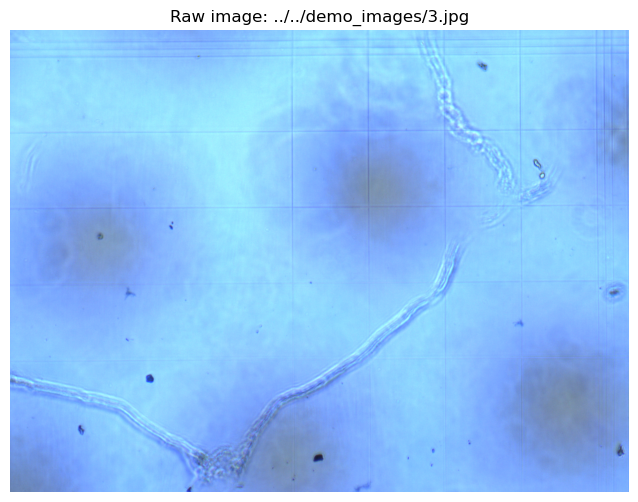

In [93]:
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

# Try a few likely locations (works whether the notebook is run from repo root or from this folder)
candidate_paths = [
    Path("../../demo_images/3.jpg"),
]
image_path = next((p for p in candidate_paths if p.exists()), None)
if image_path is None:
    raise FileNotFoundError(f"Could not find demo image. Tried: {', '.join(map(str, candidate_paths))}")

# Load image (OpenCV reads BGR)
img_bgr = cv2.imread(str(image_path))
if img_bgr is None:
    raise ValueError(f"OpenCV failed to read image: {image_path}")

# add a small rotation to the image
center = (img_bgr.shape[1] // 2, img_bgr.shape[0] // 2)
M = cv2.getRotationMatrix2D(center, angle=0, scale=1.0)
img_bgr = cv2.warpAffine(img_bgr, M, (img_bgr.shape[1], img_bgr.shape[0]))

# Display the raw image
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 6))
plt.imshow(img_rgb)
plt.title(f"Raw image: {image_path}")
plt.axis("off")
plt.show()

### Convert img_rgb to a canny edge detection binary map


Canny thresholds: low=10, high=30


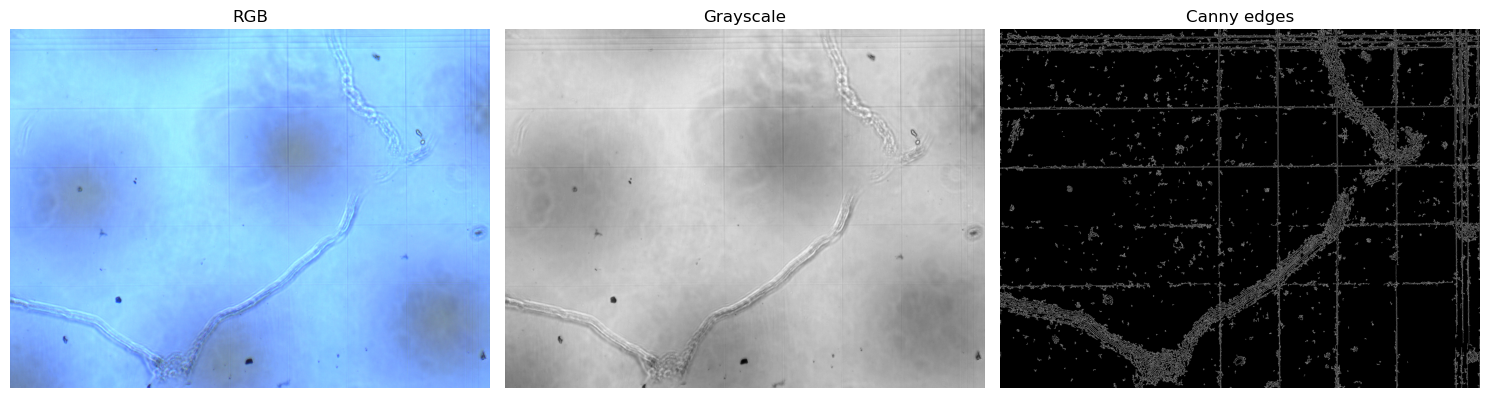

In [94]:
# Convert img_rgb to a Canny edge detection binary map (fixed thresholds for Hough grid lines)
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

# Fixed Canny thresholds (tuned for grid lines; adjust if needed)
canny_low = 10
canny_high = 30
edges = cv2.Canny(img_gray, canny_low, canny_high, apertureSize=3, L2gradient=True)

print(f"Canny thresholds: low={canny_low}, high={canny_high}")

# Display RGB, grayscale (preprocessed), and edges in a matrix
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(img_rgb)
axes[0].set_title("RGB")
axes[0].axis("off")

axes[1].imshow(img_gray, cmap="gray")
axes[1].set_title("Grayscale")
axes[1].axis("off")

axes[2].imshow(edges, cmap="gray")
axes[2].set_title("Canny edges")
axes[2].axis("off")

plt.tight_layout()
plt.show()

### Find line equations using Hough's transform

First 3 detected lines (rho, theta):
Line 1: rho=1820.00, theta=0.00 radians
Line 2: rho=43.00, theta=1.57 radians
Line 3: rho=1184.00, theta=0.00 radians


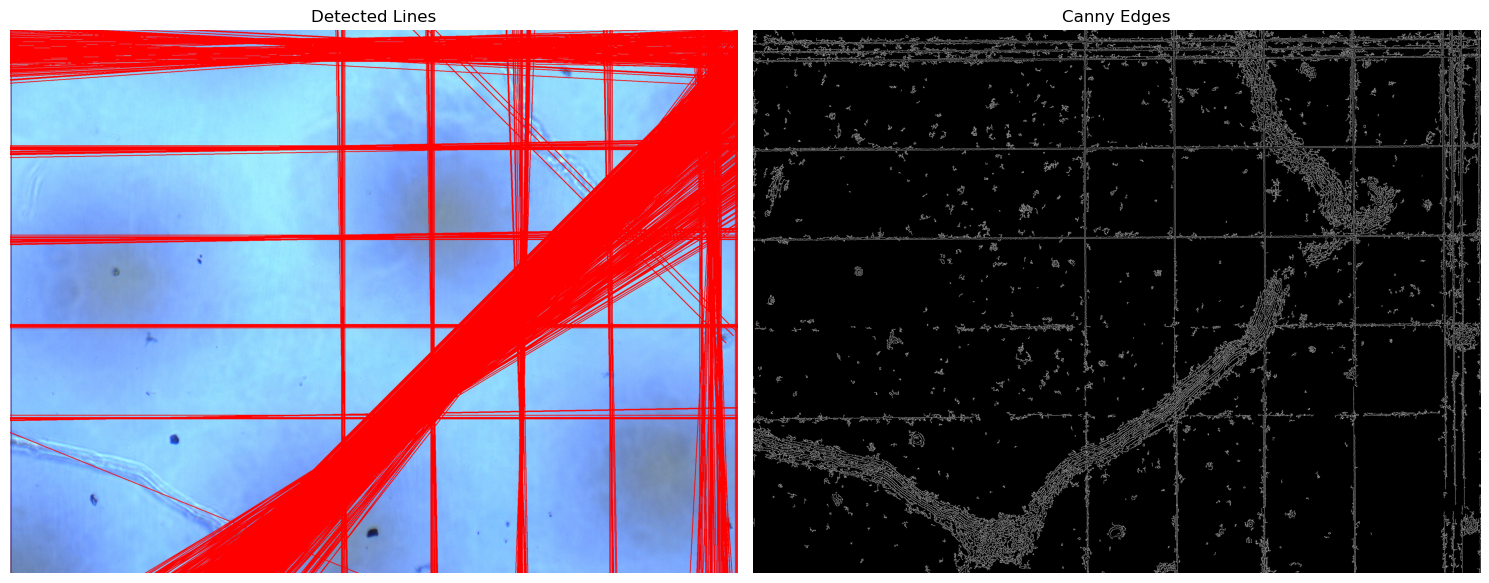

In [95]:
# Find line equations using Hough's transform
import numpy as np

lines = cv2.HoughLines(edges, 1, np.pi / 180, threshold=300)

# Print the first 3 lines detected
if lines is not None:
    print("First 3 detected lines (rho, theta):")
    for i in range(min(3, len(lines))):
        rho, theta = lines[i][0]
        print(f"Line {i+1}: rho={rho:.2f}, theta={theta:.2f} radians")
else:
    print("No lines detected.")

# Get image dimensions
height, width = img_gray.shape
max_dim = max(height, width)

# Visualize detected lines on the original image
img_lines = img_rgb.copy()
if lines is not None:
    for rho, theta in lines[:, 0, :]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        # Create two points far apart to draw an "infinite" line
        x1 = int(round(x0 + max_dim * (-b)))
        y1 = int(round(y0 + max_dim * (a)))
        x2 = int(round(x0 - max_dim * (-b)))
        y2 = int(round(y0 - max_dim * (a)))
        cv2.line(img_lines, (x1, y1), (x2, y2), (255, 0, 0), 2)

# Plot the detected lines overlay and the Canny edges side-by-side
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
axes[0].imshow(img_lines)
axes[0].set_title("Detected Lines")
axes[0].axis("off")
axes[1].imshow(edges, cmap="gray")
axes[1].set_title("Canny Edges")
axes[1].axis("off")
plt.tight_layout()
plt.show()

In [96]:
# Print the number of lines detected
if lines is not None:
    print(f"Total lines detected: {len(lines)}")
else:
    print("No lines detected.")

Total lines detected: 515


## Find squares

Now that we have line candidates in `lines`, it is time to use these line candidates to find the best squares. This will repredent the different detection zones, used for calculating the cell viability per unit of volume in each square.

What are some ways of deciding on the best square candidates?

Brainstorm:
- find all intersections between all lines
- squares are always non-overlapping
- use the strongest lines first

In [97]:
# Generate a list of intersection points based on the detected lines
# Give each intersection point a unique id and a score which is the sum of the indices of the two lines from `lines`
# Only include intersections if the two lines are close to orthogonal
import numpy as np

if lines is None or len(lines) < 2:
    intersection_points = []
    print("No intersections: need at least 2 lines.")
else:
    # Lines are in Hough normal form: x*cos(theta) + y*sin(theta) = rho
    # We'll compute intersections for all unique pairs (i < j).
    # Indices i/j below are 0-based (Python indices).
    intersection_points = []
    point_id = 0
    eps = 1e-9

    # Orthogonality filter: keep pairs where angle difference is near 90 degrees.
    # Note: For Hough normal form, orthogonality of the *lines* corresponds to |theta1 - theta2| near pi/2 (mod pi).
    orth_tol_deg = 1.0
    orth_tol = np.deg2rad(orth_tol_deg)

    for i in range(len(lines)):
        rho1, theta1 = lines[i][0]
        a1 = float(np.cos(theta1))
        b1 = float(np.sin(theta1))

        for j in range(i + 1, len(lines)):
            rho2, theta2 = lines[j][0]
            a2 = float(np.cos(theta2))
            b2 = float(np.sin(theta2))

            # Check near-orthogonality (mod pi)
            dtheta = float(abs(theta1 - theta2)) % np.pi
            # Fold into [0, pi/2]
            if dtheta > (np.pi / 2):
                dtheta = np.pi - dtheta
            if abs((np.pi / 2) - dtheta) > orth_tol:
                continue

            # Solve: [[a1, b1], [a2, b2]] * [x, y]^T = [rho1, rho2]^T
            det = a1 * b2 - a2 * b1
            if abs(det) < eps:
                # Nearly parallel lines => no stable intersection
                continue

            x = (rho1 * b2 - rho2 * b1) / det
            y = (a1 * rho2 - a2 * rho1) / det

            # Optional: keep only intersections that land within image bounds
            if not (0 <= x < width and 0 <= y < height):
                continue

            intersection_points.append(
                {
                    "id": point_id,
                    "x": float(x),
                    "y": float(y),
                    "i": int(i),
                    "j": int(j),
                    "score": int(i + j),
                }
            )
            point_id += 1

    print(
        f"Generated {len(intersection_points)} in-bounds intersection points from {len(lines)} lines "
        f"(orthogonality tolerance: ±{orth_tol_deg:.1f}°)."
    )
    if intersection_points:
        # Show a few lowest-score points (these tend to come from earlier/stronger lines)
        preview = sorted(intersection_points, key=lambda p: p["score"])[:10]
        print("First 10 points by lowest score (id, x, y, i, j, score):")
        for p in preview:
            print(p["id"], f"({p['x']:.1f}, {p['y']:.1f})", p["i"], p["j"], p["score"])

Generated 5498 in-bounds intersection points from 515 lines (orthogonality tolerance: ±1.0°).
First 10 points by lowest score (id, x, y, i, j, score):
0 (1820.0, 43.0) 0 1 1
86 (1184.0, 43.0) 1 2 3
1 (1820.0, 41.0) 0 4 4
87 (2139.0, 43.0) 1 3 4
2 (1820.0, 51.0) 0 5 5
3 (1820.0, 83.0) 0 6 6
128 (1184.0, 41.0) 2 4 6
4 (1820.0, 73.0) 0 7 7
129 (1184.0, 51.0) 2 5 7
213 (2139.0, 41.0) 3 4 7


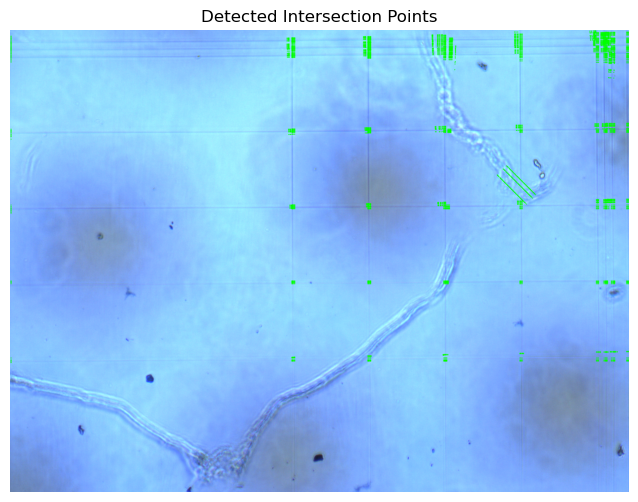

In [98]:
# overlay the intersection points on the image
img_points = img_rgb.copy()
for p in intersection_points:
    x = int(round(p["x"]))
    y = int(round(p["y"]))
    cv2.circle(img_points, (x, y), radius=2, color=(0, 255, 0), thickness=-1)  # filled circle
# Plot the detected intersection points overlay
plt.figure(figsize=(10, 6))
plt.imshow(img_points)
plt.title("Detected Intersection Points")
plt.axis("off")
plt.show()

Detected 154 grid squares from intersection points.


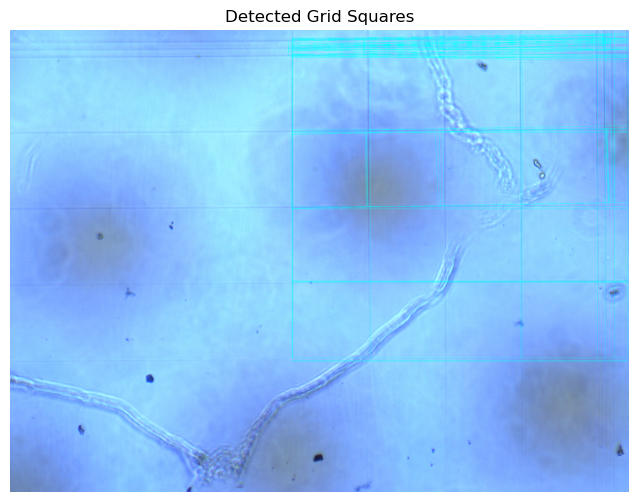

In [ ]:
# Detect grid squares from the intersection points
grid_squares = []
point_dict = {(p["i"], p["j"]): p for p in intersection_points}
for p in intersection_points:
    i, j = p["i"], p["j"]
    # Look for the other three corners of the square
    p_right = point_dict.get((i + 1, j))
    p_down = point_dict.get((i, j + 1))
    p_diag = point_dict.get((i + 1, j + 1))
    if p_right and p_down and p_diag:
        square = {
            "top_left": p,
            "top_right": p_right,
            "bottom_left": p_down,
            "bottom_right": p_diag,
        }
        grid_squares.append(square)
print(f"Detected {len(grid_squares)} grid squares from intersection points.")

# Overlay grid squares on the image
img_squares = img_rgb.copy()
grid_color = (255, 0, 0)   # red in RGB
grid_thickness = 3
for square in grid_squares:
    tl = (int(round(square["top_left"]["x"])), int(round(square["top_left"]["y"])))
    tr = (int(round(square["top_right"]["x"])), int(round(square["top_right"]["y"])))
    bl = (int(round(square["bottom_left"]["x"])), int(round(square["bottom_left"]["y"])))
    br = (int(round(square["bottom_right"]["x"])), int(round(square["bottom_right"]["y"])))
    cv2.line(img_squares, tl, tr, grid_color, grid_thickness)
    cv2.line(img_squares, tr, br, grid_color, grid_thickness)
    cv2.line(img_squares, br, bl, grid_color, grid_thickness)
    cv2.line(img_squares, bl, tl, grid_color, grid_thickness)
# Plot the detected grid squares overlay
plt.figure(figsize=(10, 6))
plt.imshow(img_squares)
plt.title("Detected Grid Squares")
plt.axis("off")
plt.show()

Squares before NMS: 154
Candidates after area filter: 151
Squares kept after IoU NMS (thr=0.1): 17


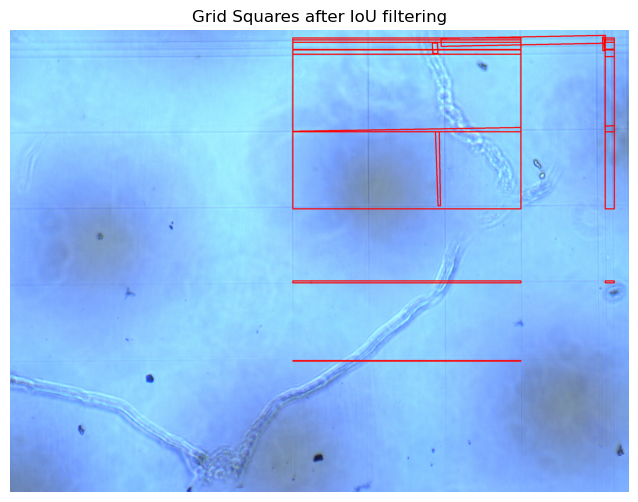

In [102]:
# Use the IoU of each square to eliminate all overlapping squares
import numpy as np

def _square_to_bbox(square):
    xs = [square[k]["x"] for k in ("top_left", "top_right", "bottom_right", "bottom_left")]
    ys = [square[k]["y"] for k in ("top_left", "top_right", "bottom_right", "bottom_left")]
    x1, y1 = float(min(xs)), float(min(ys))
    x2, y2 = float(max(xs)), float(max(ys))
    return x1, y1, x2, y2

def _bbox_iou(b1, b2, eps=1e-9):
    x11, y11, x12, y12 = b1
    x21, y21, x22, y22 = b2
    inter_x1 = max(x11, x21)
    inter_y1 = max(y11, y21)
    inter_x2 = min(x12, x22)
    inter_y2 = min(y12, y22)
    inter_w = max(0.0, inter_x2 - inter_x1)
    inter_h = max(0.0, inter_y2 - inter_y1)
    inter_area = inter_w * inter_h
    area1 = max(0.0, x12 - x11) * max(0.0, y12 - y11)
    area2 = max(0.0, x22 - x21) * max(0.0, y22 - y21)
    union = area1 + area2 - inter_area
    return inter_area / (union + eps)

def _square_score(square):
    # Lower is better: derived from line indices that formed the corners (earlier lines are usually stronger)
    return int(square["top_left"]["score"] + square["top_right"]["score"] + square["bottom_left"]["score"] + square["bottom_right"]["score"])

# NMS parameters
iou_thresh = 0.1  # two squares with IoU > thresh => keep only the better one
min_area = 250.0   # filter out tiny boxes (noise)

if not grid_squares:
    grid_squares_nms = []
    print("No grid squares to filter.")
else:
    candidates = []
    for sq in grid_squares:
        bbox = _square_to_bbox(sq)
        area = max(0.0, bbox[2] - bbox[0]) * max(0.0, bbox[3] - bbox[1])
        if area < min_area:
            continue
        candidates.append({"square": sq, "bbox": bbox, "score": _square_score(sq), "area": area})

    # Sort by score (ascending => best first)
    candidates.sort(key=lambda d: d["score"])

    kept = []
    for cand in candidates:
        if all(_bbox_iou(cand["bbox"], k["bbox"]) <= iou_thresh for k in kept):
            kept.append(cand)

    grid_squares_nms = [k["square"] for k in kept]
    print(f"Squares before NMS: {len(grid_squares)}")
    print(f"Candidates after area filter: {len(candidates)}")
    print(f"Squares kept after IoU NMS (thr={iou_thresh}): {len(grid_squares_nms)}")

# Overlay filtered squares on the image
img_squares_nms = img_rgb.copy()
grid_color = (255, 0, 0)   # red in RGB
grid_thickness = 3
for square in grid_squares_nms:
    tl = (int(round(square["top_left"]["x"])), int(round(square["top_left"]["y"])))
    tr = (int(round(square["top_right"]["x"])), int(round(square["top_right"]["y"])))
    bl = (int(round(square["bottom_left"]["x"])), int(round(square["bottom_left"]["y"])))
    br = (int(round(square["bottom_right"]["x"])), int(round(square["bottom_right"]["y"])))
    cv2.line(img_squares_nms, tl, tr, grid_color, grid_thickness)
    cv2.line(img_squares_nms, tr, br, grid_color, grid_thickness)
    cv2.line(img_squares_nms, br, bl, grid_color, grid_thickness)
    cv2.line(img_squares_nms, bl, tl, grid_color, grid_thickness)

plt.figure(figsize=(10, 6))
plt.imshow(img_squares_nms)
plt.title("Grid Squares after IoU filtering")
plt.axis("off")
plt.show()